<a href="https://colab.research.google.com/github/sunbrn/SciCommEng/blob/master/qr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esegui prima cella e alla conclusione **riavvia il runtime!**

In [ ]:
%%time

# Questo notebook è stato arrangiato da carlo.bono@polimi.it googlando furiosamente
# (fammi un fischio se si può migliorare qualcosa)

!sudo apt-get update
!apt install libzbar0
!apt install poppler-utils
# !pip install kraken
!pip install pymupdf reportlab pylabels qrcode pyzbar pdf2image

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,614 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,047 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/m

In [ ]:
# test file, the real 'Dettaglio elenco studenti.xlsx' file should be uploaded using the Colab menu on the left
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IWUhZHU9yxJa2TmhCoU2r2gaHKb1GzY3' -O 'Dettaglio elenco studenti.xlsx'

--2023-07-20 15:52:24--  https://docs.google.com/uc?export=download&id=1IWUhZHU9yxJa2TmhCoU2r2gaHKb1GzY3
Resolving docs.google.com (docs.google.com)... 142.251.2.101, 142.251.2.102, 142.251.2.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t3ubb6simucj8n3qtruf7grarntdg7jq/1689868275000/00776265667024010084/*/1IWUhZHU9yxJa2TmhCoU2r2gaHKb1GzY3?e=download&uuid=43670bed-7c90-4683-a5fa-166caf3fd431 [following]
--2023-07-20 15:52:25--  https://doc-0k-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t3ubb6simucj8n3qtruf7grarntdg7jq/1689868275000/00776265667024010084/*/1IWUhZHU9yxJa2TmhCoU2r2gaHKb1GzY3?e=download&uuid=43670bed-7c90-4683-a5fa-166caf3fd431
Resolving doc-0k-68-docs.googleusercontent.com (doc-0k-68-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:402

In [ ]:
#@title >>Fase 1: Genera PDF<< </br>Genera PDF stampabile con molteplici QR a partire da un anagrafica CSV (carica excel dal menu a sinistra) </br> NB: da stampare in scala 100% (non adattato alla pagina) { run: "auto" }
input_excel = "Dettaglio elenco studenti-20.xlsx" #@param {type:"string"}
output_pdf = "etichette-gigi.pdf" #@param {type:"string"}
num_labels_per_id =  2#@param {type:"integer"}
skip_first =  0#@param {type:"integer"}


In [ ]:
# Genera PDF stampabile con QR a partire da un anagrafica CSV
# https://stackoverflow.com/questions/55791751/how-to-draw-images-on-labels

import labels
import qrcode
import json
import string
from reportlab.graphics import shapes
from random import randint, randrange, choice
from reportlab.graphics.shapes import Image
from reportlab.lib import colors
import textwrap

# Create an A4 portrait (210mm x 297mm) sheets with 3 columns and 8 rows
# https://github.com/bcbnz/pylabels/blob/master/labels/specifications.py

# Stampante Ed 21 3rd Floor uses this margins: top_margin=10, bottom_margin=15 (inner feed)
# Format Avery 24x L4773
#specs = labels.Specification(210, 297, 3, 8, 63, 34, corner_radius=2,
#    left_padding=2, top_padding=2, bottom_padding=2, right_padding=2, padding_radius=0,
#    left_margin=8, right_margin=7, top_margin=10, bottom_margin=15, row_gap=0, column_gap=3)

# Stampante Ed 21 3rd Floor (multipurpose feed, horizontal/wide side input)
# Format Avery 24x L7159
specs = labels.Specification(210, 297, 3, 8, 63, 34, corner_radius=2,
    left_padding=2, top_padding=2, bottom_padding=2, right_padding=2, padding_radius=0,
    left_margin=8, right_margin=7, top_margin=8, bottom_margin=10, row_gap=1, column_gap=3)

# Stampante Ed 20 1st Floor new hall uses this margins: top_margin=13, bottom_margin=12 (multipurpose feed)
# Format Avery 24x L4773
# specs = labels.Specification(210, 297, 3, 8, 63, 34, corner_radius=2,
#     left_padding=2, top_padding=2, bottom_padding=2, right_padding=2, padding_radius=0,
#     left_margin=8, right_margin=7, top_margin=13, bottom_margin=12, row_gap=0, column_gap=3)


# Create a function to draw each label. This will be given the ReportLab drawing
# object to draw on, the dimensions (NB. these will be in points, the unit
# ReportLab uses) of the label, and the object to render.
def draw_label(label, width, height, obj, fill=colors.black):
    config = obj.get('config')

    # selective colors
    fill = colors.black
    if 'fill' in config: fill = config['fill']

    mylines = textwrap.wrap(config.get("n"), 13) # wrap name

    if len(mylines) >3: # 4 lines
      # w, h from bottom right
      label.add(shapes.String(80, 64, f'{config.get("c")}', fontName="Helvetica", fontSize=10, fillColor=fill))
      label.add(shapes.String(80, 51, mylines[0], fontName="Helvetica", fontSize=10, fillColor=fill))
      label.add(shapes.String(80, 38, mylines[1], fontName="Helvetica", fontSize=10, fillColor=fill))
      label.add(shapes.String(80, 25, mylines[2], fontName="Helvetica", fontSize=10, fillColor=fill))
      label.add(shapes.String(80, 12, ' '.join(mylines[3:])[:14], fontName="Helvetica", fontSize=10, fillColor=fill))
    elif len(mylines) >2: # 3 lines
      # w, h from bottom right
      label.add(shapes.String(80, 51, f'{config.get("c")}', fontName="Helvetica", fontSize=10, fillColor=fill))
      label.add(shapes.String(80, 38, mylines[0], fontName="Helvetica", fontSize=10, fillColor=fill))
      label.add(shapes.String(80, 25, mylines[1], fontName="Helvetica", fontSize=10, fillColor=fill))
      label.add(shapes.String(80, 12, ' '.join(mylines[2:])[:14], fontName="Helvetica", fontSize=10, fillColor=fill))
    elif len(mylines) >1: # 2 lines
      label.add(shapes.String(80, 38, f'{config.get("c")}', fontName="Helvetica", fontSize=10, fillColor=fill))
      label.add(shapes.String(80, 25, mylines[0], fontName="Helvetica", fontSize=10, fillColor=fill))
      label.add(shapes.String(80, 12, ' '.join(mylines[1:])[:14], fontName="Helvetica", fontSize=10, fillColor=fill))
    else: # 1 line
      label.add(shapes.String(80, 25, f'{config.get("c")}', fontName="Helvetica", fontSize=10, fillColor=fill))
      label.add(shapes.String(80, 12, mylines[0], fontName="Helvetica", fontSize=10, fillColor=fill))

    # label.add(shapes.Image(4, 12, 60, 60, obj.get('image')))
    label.add(shapes.Image(0, 0, 80, 80, obj.get('image')))


# Create the PDF sheet
sheet = labels.Sheet(specs, draw_label, border=False)

# Load the student file
import pandas as pd
df = pd.read_excel(input_excel)

# Skip first N: add dummies (for paper recycling)
for i in range(skip_first):
  dummy_dict = {'c': 'a', 'n': 'a'}

  qr = qrcode.QRCode(version=1, error_correction=qrcode.constants.ERROR_CORRECT_M,
      box_size=32,border=4)
  qr.add_data(json.dumps(dummy_dict))
  qr.make(fit=True)
  dummy_dict['fill'] = colors.white
  qr_code = {'config': dummy_dict, 'image': qr.make_image(fill_color="white", back_color="white")}
  sheet.add_label(qr_code)

# For each student
for i in df[['Codice persona', 'Cognome-Nome']].itertuples():

        setup_dict = {
            'c': i[1], # c stands for code
            'n': i[2] # n stands for name
        }

        qr = qrcode.QRCode(
            version=1,
            error_correction=qrcode.constants.ERROR_CORRECT_M,
            box_size=32,
            border=4,
        )

        # Add JSON encoded data to qr code
        qr.add_data(json.dumps(setup_dict))

        qr.make(fit=True)

        qr_code = {
            'config': setup_dict,
            'image': qr.make_image(fill_color="black", back_color="white"),
        }

        # When a single QR per studenti ipools not enough
        for _ in range(num_labels_per_id):
          sheet.add_label(qr_code)

# Save the file and we are done.
sheet.save(output_pdf)

### Download della pigrizia (si può scaricare il file PDF con i QR anche dal menu a sinistra)

In [ ]:
from google.colab import files
files.download(output_pdf)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title >>Fase 2: Leggi QR<< </br> Leggi cartella di scansioni PDF e rinominali con il primo QR trovato in prima pagina (in una cartella separata) { run: "auto" }
in_folder = "input_Ese" #@param {type:"string"}
out_folder = "output_Ese" #@param {type:"string"}
CYCLE_ALL_PAGES = False #@param {type:"boolean"}


## 1. Leggi i QR dalla prima pagina dei PDF forniti
Crea cartella dal menu a sinistra, e poi [...] sulla cartella per upload dei file.</br>
Se il qr non viene trovato, il file viene copiato con il nome originale

In [ ]:
%%time

try:
  in_folder
except Exception as e:
  print("(!) Esegui il blocco di configurazione delle cartelle!")
  raise

!rm -r /content/$out_folder; mkdir /content/$out_folder

import glob, os
from pdf2image import convert_from_path
from pyzbar.pyzbar import ZBarSymbol
from pyzbar.pyzbar import decode
import ast
import shutil
import glob


def extractqr_(fname):
  # https://pdf2image.readthedocs.io/en/latest/reference.html
  iname = os.path.join('/content', in_folder, fname)

  # Choose if to look for qr also on other pages (break wehn you find it)
  if CYCLE_ALL_PAGES: imas = convert_from_path(iname, 100)
  else: imas = convert_from_path(iname, 100, first_page=1,last_page=1)

  oname = os.path.join('/content', out_folder, fname) # in case it fails

  for n,ima in enumerate(imas):

    dec = decode(ima, symbols=[ZBarSymbol.QRCODE])

    if len(dec):
      val = ast.literal_eval(dec[0].data.decode('utf-8'))
      oname = os.path.join('/content', out_folder, str(val['c']) + "_" + str(val['n']) + ".pdf")
      break

  # Copy the file, with or without renaming
  shutil.copy(iname, oname)

  return dec

from multiprocessing import Pool
import tqdm
pool = Pool(processes=4)

found = 0
os.chdir('/content/'+in_folder)
tasks = glob.glob("*.pdf")

for _ in tqdm.tqdm(pool.imap_unordered(extractqr_, tasks), total=len(tasks), position=0, leave=True):
    if len(_): found += 1

print('\n', found, '/', len(tasks))

rm: cannot remove '/content/output_Ese': No such file or directory


100%|██████████| 15/15 [00:02<00:00,  6.61it/s]


 8 / 15
CPU times: user 88.6 ms, sys: 43.8 ms, total: 132 ms
Wall time: 2.33 s


## 2. Scarica i PDF rinominati
(lento! l'integrazione con google drive, sia per input che per output, è più comoda... vedi il primo blocco sotto "Fine!")

In [ ]:
!zip -r /content/file.zip /content/$out_folder
from google.colab import files
files.download("/content/file.zip")

  adding: content/output_Ese/ (stored 0%)
  adding: content/output_Ese/10782878_PENNISI TECLA.pdf (deflated 55%)
  adding: content/output_Ese/doc01322420240109162029_007.pdf (deflated 49%)
  adding: content/output_Ese/10833748_MENON ANDREA.pdf (deflated 48%)
  adding: content/output_Ese/10682857_PALESTRA LEONARDO.pdf (deflated 50%)
  adding: content/output_Ese/10744458_NICOLOSI DARIO.pdf (deflated 55%)
  adding: content/output_Ese/10764144_NEGRI NICCOLÒ.pdf (deflated 52%)
  adding: content/output_Ese/doc01322420240109162029_013.pdf (deflated 53%)
  adding: content/output_Ese/doc01322420240109162029_008.pdf (deflated 46%)
  adding: content/output_Ese/10810559_MORO GIACOMO OTTORINO.pdf (deflated 52%)
  adding: content/output_Ese/doc01322420240109162029_006.pdf (deflated 49%)
  adding: content/output_Ese/10676357_NADALIN BEATRICE TERESA.pdf (deflated 55%)
  adding: content/output_Ese/doc01322420240109162029_005.pdf (deflated 50%)
  adding: content/output_Ese/doc01322420240109162029_009.pd

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Fine!
sotto ci sono solo prove e perdizione

In [ ]:
# Mount colab and choose input folder

# %%capture

if False:

  # Scegli un file (MyDrive diventa un path qualunque su colab)
  !pip install ipyfilechooser

  from google.colab import drive
  drive.mount('/content/drive')

  from ipyfilechooser import FileChooser

  # Create and display a FileChooser widget
  fc = FileChooser('/content/drive/MyDrive')
  display(fc)

  # Set infolder
  fc.selected_path.replace('/content/', '')

  # Set outfolder
  # ...

  CYCLE_ALL_PAGES = False

  # Settando infolder e outfolder si scrivono i file direttamente su google drive...
  # quindi anche il passaggio di zippare e scaricare diventa pleonastico


In [ ]:
# Not very usable since it uploads one file at time...
#from google.colab import files
#uploaded = files.upload()

#for fn in uploaded.keys():
#  print('User uploaded file "Uploading_Data_Colab_1.xlsx" with length 9000 bytes'.format(
#      name=fn, length=len(uploaded[fn])))

Nothing to see here, just the original (slower) prototype for decoding...

In [ ]:
%%time


# FIRST VERSION

from PIL import Image
from kraken import binarization
from pyzbar.pyzbar import ZBarSymbol
from pyzbar.pyzbar import decode
import fitz
import ast
import shutil
import glob
import os
import io
import cv2
import numpy as np

os.chdir('/content/')

# extract qr data from first page of a raster pdf
def extractqr(fname):
  doc = fitz.Document(fname)
  page0 = doc.get_page_images(0)
  xref = page0[0]
  image = doc.extract_image(xref[0])
  pix = fitz.Pixmap(doc, xref[0])
  ima = Image.open(io.BytesIO(pix.tobytes()))

  # Antialiasing is beneficial...
  w, h = ima.size
  targeth = 1024
  ratio = targeth/h
  neww = int(ratio*w)
  ima.thumbnail((neww, targeth), Image.Resampling.LANCZOS)
  # ima.thumbnail((int(w/4), int(h/4)), Image.Resampling.LANCZOS) # works smoothly at 1753 x 1240 (1/4 wrt 600dpi)

  # check CV2 detection (not perfect...)
  #import numpy as np
  #open_cv_image = np.array(ima)
  #qrCodeDetector = cv2.QRCodeDetector()
  #doable, points = qrCodeDetector.detect(open_cv_image)

  # Try raw decode
  dec = decode(ima, symbols=[ZBarSymbol.QRCODE])

  if len(dec) == 0:
    print("Could not decode a QR, try with OpenCV thresholding...")
    # to cv2
    open_cv_image = np.array(ima)

    blur = cv2.GaussianBlur(open_cv_image, (5, 5), 0)
    ret, bw_im1 = cv2.threshold(blur, 200, 255, cv2.THRESH_BINARY)
    dec = decode(bw_im1, symbols=[ZBarSymbol.QRCODE])

  if len(dec) == 0:
    print("Could not decode a QR, try with nlbin...")
    bw_im = binarization.nlbin(ima)
    dec = decode(bw_im, symbols=[ZBarSymbol.QRCODE])

  return dec

# remove and recreate output directory
!rm -r $out_folder; mkdir $out_folder
# nessuna gestione delle eccezioni: se qualcosa non funziona si rompe tutto

os.chdir('/content/'+in_folder)
for fname in glob.glob("*.pdf"):
  print("###", fname)
  o = extractqr(fname)
  print("Extracting first code among " + str(len(o)) + " found.")

  if len(o) < 1:
    print("(!!!) COULD NOT DECODE " + fname + ", copying with the original name")
    shutil.copy(fname, os.path.join('/content', out_folder, fname))
    continue

  val = o[0].data
  val = ast.literal_eval(val.decode('utf-8')) # binary to dict
  code = str(val['c']) # code
  name = str(val['n']) # name
  print(code, name)

  shutil.copy(fname, os.path.join('/content', out_folder, code + "_" + name + ".pdf"))

Random tests with Data Matrix follow...

In [ ]:
!apt install libdmtx0a
!pip install pylibdmtx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


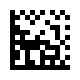

In [ ]:
from pylibdmtx.pylibdmtx import encode
from PIL import Image
encoded = encode('10021100'.encode('utf8'))
img.save('test.jpg')
img = Image.frombytes('RGB', (encoded.width, encoded.height), encoded.pixels)
img

In [ ]:
from pylibdmtx.pylibdmtx import decode
from PIL import Image
decode(Image.open('test.jpg'))

[Decoded(data=b'10021100', rect=Rect(left=8, top=9, width=63, height=59))]

In [ ]:
%%timeit

image = cv2.imread('test.jpg')
height, width = image.shape[:2]
decode((image.tobytes(), width, height), max_count=1) # threshold=50, min_edge=20, max_edge=60

1000 loops, best of 5: 1.32 ms per loop
